In [1]:
# Standard libraries
import os
import sys
import datetime
import argparse
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path

# Third-party libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
from tqdm.autonotebook import tqdm
from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.ndimage import gaussian_filter

# Project-specific imports
from scripts.utils.metrics import (
    calculate_flux_statistics, 
    cross_match_catalogs, 
    construct_matched_catalog
)
from scripts.utils.data_loader import (
    load_input_data_asarray,
    load_target_data_asarray
)
from scripts.utils.file_utils import (
    get_main_dir,
    setup_directories,
    create_model_results_subfolder
)

from scripts.utils.evaluation_plots import (
    plot_binned_iqr,
    contourplot_completeness_reliability,
    plot_completeness_reliability,
    pos_flux_plot,
    plot_image_grid,
    pos_flux_cornerplot_deprecated,

)

from models.architectures.UnetResnet34Tr import UnetResnet34Tr
from models.architectures.UnetResnet34TrNew import UnetResnet34TrNew
from models.architectures.SwinUnet import swin_unet_2d_base
from models.architectures.Unet import build_unet

2025-11-27 17:22:32.426414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 17:22:32.571219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 17:22:33.874770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/tmp/ipykernel_371123/241729965.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tq

In [2]:
# Configure logger and warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", module="photutils")

### Functions

In [3]:
# Load configuration
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


In [4]:
def process_catalogs(path_sim_cats, catalog_paths):
    total_area = 0
    composite_cat = pd.DataFrame()  # Initialize an empty DataFrame
    
    for catalog_path in catalog_paths:
        with fits.open(os.path.join(path_sim_cats, catalog_path), memmap=False) as hdu:
            cat = pd.DataFrame(hdu[1].data).astype('<f8')[["ra", "dec", "SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"]]
            
            # Update the total area
            total_area += (np.max(cat["ra"]) - np.min(cat["ra"])) * (np.max(cat["dec"]) - np.min(cat["dec"]))
            
            # Concatenate catalogs
            composite_cat = pd.concat([composite_cat, cat], ignore_index=True, copy=False)
    
    return total_area, composite_cat

In [5]:
def compute_R_C(input_cat, output_cat, flux_col_input, flux_col_output, bins, search_radius=4.0):
    # Cross‑match catalogs
    matched_from_input = cross_match_catalogs(
        output_cat, input_cat, flux_col_output, flux_col_input, search_radius
    )
    matched_from_output = cross_match_catalogs(
        input_cat, output_cat, flux_col_input, flux_col_output, search_radius
    )

    # Prepare the table for the flux bins
    flux_bins = [(low, high) for low, high in zip(bins[:-1], bins[1:])]
    n_bins    = len(flux_bins)
    zero_list = [0] * n_bins
    nan_list  = [np.nan] * n_bins

    metrics_df = pd.DataFrame({
        'Flux bin': flux_bins,
        'TPc'     : zero_list,   # true positives for completeness
        'FNc'     : zero_list,   # false negatives for completeness
        'C'       : nan_list,    # completeness = TPc/(TPc+FNc)
        'cum_C'   : nan_list,    # cumulative completeness
        'TPr'     : zero_list,   # true positives for reliability
        'FPr'     : zero_list,   # false positives for reliability
        'R'       : nan_list,    # reliability = TPr/(TPr+FPr)
        'cum_R'   : nan_list,    # cumulative reliability
    })

    # Compute bin centers, completeness, and reliability
    for idx, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
        # --- completeness side
        in_bin     = (input_cat[flux_col_input]  >= low) & (input_cat[flux_col_input]  < high)
        n_in       = in_bin.sum()
        tp_c       = ((matched_from_input[flux_col_input] >= low) &
                      (matched_from_input[flux_col_input] < high)).sum()
        fn_c       = n_in - tp_c

        # --- reliability side
        out_bin    = (output_cat[flux_col_output] >= low) & (output_cat[flux_col_output] < high)
        n_out      = out_bin.sum()
        tp_r       = ((matched_from_output[flux_col_output] >= low) &
                      (matched_from_output[flux_col_output] < high)).sum()
        fp_r       = n_out - tp_r

        # --- completeness & reliability fractions
        comp = tp_c / n_in if n_in > 0 else np.nan
        rel  = tp_r / n_out if n_out > 0 else np.nan

        # Fill row
        metrics_df.at[idx, 'TPc'] = tp_c
        metrics_df.at[idx, 'FNc'] = fn_c
        metrics_df.at[idx,  'C']  = comp

        metrics_df.at[idx, 'TPr'] = tp_r
        metrics_df.at[idx, 'FPr'] = fp_r
        metrics_df.at[idx,  'R']  = rel

    # Compute cumulative True Positives, False Negatives etc
    metrics_df["TPr_cum"] = metrics_df["TPr"][::-1].cumsum()[::-1]
    metrics_df["FPr_cum"] = metrics_df["FPr"][::-1].cumsum()[::-1]
    metrics_df["TPc_cum"] = metrics_df["TPc"][::-1].cumsum()[::-1]
    metrics_df["FNc_cum"] = metrics_df["FNc"][::-1].cumsum()[::-1]

    # Do not compute cumulative metrics if there are no matches
    mask = (metrics_df["TPr"] + metrics_df["FPr"]) == 0
    metrics_df.loc[mask, "TPr_cum"] = np.nan
    metrics_df.loc[mask, "FPr_cum"] = np.nan

    for i in range(len(metrics_df)):
        # Compute the cumulative Completeness and Reliability
        den_C = metrics_df.loc[i, "TPc_cum"] + metrics_df.loc[i, "FNc_cum"]
        metrics_df.at[i, 'cum_C'] = metrics_df.loc[i, "TPc_cum"] / den_C if den_C > 0 else np.nan

        den_R = metrics_df.loc[i, "TPr_cum"] + metrics_df.loc[i, "FPr_cum"]
        metrics_df.at[i, 'cum_R'] = metrics_df.loc[i, "TPr_cum"] / den_R if den_R > 0 else np.nan

    # Append another column containing denominators
    metrics_df['den_C'] = metrics_df['TPc'] + metrics_df['FNc']
    metrics_df['den_R'] = metrics_df['TPr'] + metrics_df['FPr']
    metrics_df['den_C_cum'] = metrics_df['TPc_cum'] + metrics_df['FNc_cum']
    metrics_df['den_R_cum'] = metrics_df['TPr_cum'] + metrics_df['FPr_cum']

    return metrics_df

In [6]:
def calculate_correction_factor(cat_input, cat_SR, flux_col_input='SSPIRE500', flux_col_output='S500SR', bins=20):
    '''cat_input: input catalog (simulated)
       cat_SR: output catalog (SPIRE SR)
       flux_col_input: flux column name in input catalog
       flux_col_output: flux column name in output catalog
       bins: number of bins or array of bin edges
    '''

    # 1. Histogram of the input catalog
    H_inp, _ = np.histogram(cat_input[flux_col_input], bins=bins)

    # 2. Histogram of the SR catalog
    H_SR, _ = np.histogram(cat_SR[flux_col_output], bins=bins)

    # 4. Calculate the correction factor f(S) = N_input(S) / N_SR(S).
    # This corrects for reliability, completeness and flux boosting.
    correction_factor = np.divide(H_inp, H_SR, out=np.ones_like(H_inp, dtype=float), where=H_SR!=0)

    return correction_factor, bins

In [7]:
def calculate_histogram_simulations(flux_data, survey_area, max_flux):
    counts, bin_edges = np.histogram(flux_data, bins=np.logspace(-3, np.log10(max_flux), 20))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    counts_per_deg2 = (counts / survey_area) / np.diff(bin_edges)
    return bin_centers, counts_per_deg2

def get_ncounts_simulations(flux_data, survey_area, max_flux, return_err=False):
    # Calculate the histogram of flux data within the survey area
    flux_values, counts_per_sqdeg = calculate_histogram_simulations(flux_data, survey_area, max_flux)
    
    # Renormalize number counts to sr and apply the S^2.5 factor
    renormalized_counts_sr = counts_per_sqdeg * flux_values ** 2.5 * 1/deg2_to_sr

    if return_err:
        yerr = np.sqrt(counts_per_sqdeg) * flux_values ** 2.5 * 1/deg2_to_sr
        return flux_values*1e3, renormalized_counts_sr, yerr
    
    return flux_values*1e3, renormalized_counts_sr

# Conversion dictionary based on conversion options
deg2_to_sr = 1/3283  # squared degree to steradian
conversion_factors = {
    0: {"multiplier": 1, "description": "Jy^1.5/sr"},  # No conversion
    1: {"multiplier": 1 / deg2_to_sr, "description": "Jy^1.5/deg^2"},
    2: lambda flux: (flux * 1e-3) ** 2.5 * (1e-3) **(-1) * (deg2_to_sr)**(-1), # dN/dS in mJy^(-1) deg^(-2)
    3: lambda flux: (flux * 1e-3) ** 2.5 / deg2_to_sr,  # dN/dS in Jy^(-1) deg^(-2)
    4: lambda flux: (flux * 1e-3) ** 2.5  # dN/dS (sr^(-1))
}

def renormalize_counts(flux, counts, err1, err2, conversion_opt=0):
    # Handle conversion option 3 separately as it depends on flux
    if conversion_opt >= 2:
        multiplier = conversion_factors[conversion_opt](flux)
    else:
        multiplier = conversion_factors[conversion_opt]["multiplier"]
    
    # Apply multiplier to counts and errors
    return flux, counts * multiplier, err1 * multiplier, err2 * multiplier
    

### Setup

In [8]:
config_path = "/mnt/d/SPIRE-SR-AI/configs/evaluate.yaml"

config = load_config(config_path)

# Initialize model and results paths
model_weights_path, sim_results_dir = setup_directories(config)


In [9]:
## Load the input, native, target and SR catalogs
# Read the FITS files into Table objects
input_table = Table.read(config['data']['input_catalog_path'])
target_table = Table.read(config['data']['target_catalog_path'])
sr_table = Table.read(os.path.join(sim_results_dir, f"{config['data']['target'][0]}_SR_catalog_pad0.fits"))

# Convert the tables to pandas DataFrames
df_target = target_table.to_pandas()
df_sr = sr_table.to_pandas()
df_input = input_table.to_pandas()

target_cl = config["data"]["target"][0]  # Assuming only one target class for now
# Set the source flux columns to be in mJy
df_target["source_flux_target"] *= 1000
df_sr[f"S{target_cl}"] *= 1000
df_input["SSPIRE500"] *= 1000
# We mask all catalogs to only include sensible fluxes for which our method is valid
# Note toself: We need to do this in a loop when doing it for more bands
flux_min, flux_max = 2, 100
df_target = df_target[(df_target["source_flux_target"] >= flux_min) & (df_target["source_flux_target"] <= flux_max)]
df_sr = df_sr[(df_sr["S500SR"] >= flux_min) & (df_sr["S500SR"] <= flux_max)]
df_input = df_input[(df_input["SSPIRE500"] >= flux_min) & (df_input["SSPIRE500"] <= flux_max)]

### Calculate the number counts

In [10]:
catalog_paths_SHARK = [f"SHARK_{i+1}_cat.fits" for i in range(15)]
catalog_paths_SIDES = [f"SIDES_{i+1}_cat.fits" for i in range(15)]

dir_sim_cats = "/mnt/g/data/PhD Projects/SR/sim_catalogs"
path_scuba_cat = "/mnt/d/SPIRE-SR-AI/data/raw/catalogs/obs/STUDIES-COSMOS_450um_v20230206.fits"
path_xid_cat = "/mnt/g/data/PhD Projects/SR/Master_Catalogue_MIPS_PACS_SPIRE_SCUBA.fits"
sr_path_obs_cat = "/mnt/d/SPIRE-SR-AI/results/SwinUnet/SwinUnetNov_noisy/testing/observations/cosmos_SR_catalog.fits"

In [11]:
sides_area, sides_cat = process_catalogs(dir_sim_cats, catalog_paths_SIDES)
shark_area, shark_cat = process_catalogs(dir_sim_cats, catalog_paths_SHARK)

In [12]:
xid_cat = pd.DataFrame(fits.open(path_xid_cat , memmap=False)[1].data)
xid_area = (np.max(xid_cat["RA"]) - np.min(xid_cat["RA"])) * (np.max(xid_cat["Dec"]) - np.min(xid_cat["Dec"]))

In [13]:
sr_cat = Table.read(sr_path_obs_cat).to_pandas()
sr_area = 2.2 # deg^2. This is exactly known from the given square boundaries in gen_obs_data.py

# Cut the SR catalog to only include sources >= 2 mJy
sr_cat = sr_cat[sr_cat['S500SR'] >= 2e-3]

In [14]:
flux_sides, renormalized_counts_sides = get_ncounts_simulations(sides_cat["SSPIRE500"], sides_area, 100e-3)
flux_shark, renormalized_counts_shark = get_ncounts_simulations(shark_cat["SSPIRE500"], shark_area, 100e-3)
# flux_spritz, renormalized_counts_spritz = get_ncounts_simulations(spritz_cat["SSPIRE500"], spritz_area, 100e-3)

flux_xid, renormalized_counts_xid, err_xid = get_ncounts_simulations(xid_cat["F_500"]*1e-3, xid_area, 60e-3, return_err=True)


#### Bootstrapping SR counts

In [15]:
import math

# Determine ra/dec boundaries of the sr_cat catalog
ra_min, ra_max = sr_cat['ra'].min(), sr_cat['ra'].max()
dec_min, dec_max = sr_cat['dec'].min(), sr_cat['dec'].max()

# Patch configuration
patch_area = 0.2
patch_side = math.sqrt(patch_area)

# Create a grid of non-overlapping patch centers covering the catalog area
ra_centers = np.arange(ra_min + patch_side/2, ra_max, patch_side)
dec_centers = np.arange(dec_min + patch_side/2, dec_max, patch_side)
centers = [(ra, dec) for ra in ra_centers for dec in dec_centers]
n_patches = len(centers)

# Number of bootstrap replicates
n_bootstrap = 10000
bootstrap_counts_list = []

with Progress(
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
    TimeElapsedColumn()
) as progress:
    task = progress.add_task("[cyan]Bootstrapping...", total=n_bootstrap)

    for i in range(n_bootstrap):
        # Randomly sample n_patches centers from the grid (with replacement)
        sampled_indices = np.random.choice(n_patches, n_patches, replace=True)
        sampled_centers = [centers[j] for j in sampled_indices]

        aggregated_flux = []
        # For each sampled center, select all sources in its patch (patch centered and with side length = patch_side)
        for (ra_center, dec_center) in sampled_centers:
            ra_low = ra_center - patch_side/2
            ra_high = ra_center + patch_side/2
            dec_low = dec_center - patch_side/2
            dec_high = dec_center + patch_side/2

            patch = sr_cat[(sr_cat['ra'] >= ra_low) & (sr_cat['ra'] <= ra_high) &
                           (sr_cat['dec'] >= dec_low) & (sr_cat['dec'] <= dec_high)]
            if not patch.empty:
                aggregated_flux.extend(patch["S500SR"].values)
        
        aggregated_flux = np.array(aggregated_flux)
        total_area = n_patches * patch_area  # Total area is number of patches times the area per patch
        
        # Skip bootstrap replicate if no sources were found
        if aggregated_flux.size == 0:
            progress.advance(task)
            continue

        # Compute the number counts for the aggregated flux in this bootstrap replicate
        flux_val, ren_counts, _ = get_ncounts_simulations(aggregated_flux, total_area, 60e-3, return_err=True)
        bootstrap_counts_list.append(ren_counts)
        
        progress.advance(task)

# Stack bootstrap realizations; each row corresponds to one replicate
bootstrap_counts_array = np.array(bootstrap_counts_list)

# Compute the mean and standard deviation at each flux bin over all replicates
median_counts = np.mean(bootstrap_counts_array, axis=0)
std_counts = np.std(bootstrap_counts_array, axis=0)

# Use the flux bins from any replicate (they are identical) and assign the computed median and std values.
flux_sr = flux_val
renormalized_counts_sr = median_counts
err_sr = std_counts

Output()

### Literature Counts

#### SPIRE 500 micron counts

In [16]:
# Valiante, blind, GAMA9
valiante_flux = np.array([25.4, 31.2, 38.3, 47.0, 57.8, 71.0, 87.2, 107.2])
renormalized_counts_valiante_deg2 = np.array([1.6, 1.412, 1.142, 0.626, 0.160, 0.117, 0.142, 0.009])
err_valiante_deg2 = np.array([0.043, 0.046, 0.063, 0.028, 0.035, 0.027, 0.025, 0.014])

# Bethemin, Stacking, COSMOS
bethermin_flux = np.array([2.1, 3.0, 4.2, 6.0, 8.4, 11.9, 16.8, 23.8, 33.6, 47.4, 67.0, 94.6])
renormalized_counts_bethermin = np.array([3465, 5216, 7244, 12170, 11446, 9917, 7540, 6298, 4548, 1143, 343, 202])
err_bethermin = np.array([864, 783, 1089, 1764, 1716, 2089, 2665, 675, 656, 343, 251, 230])

# Oliver, blind, COMBINED
oliver_flux = np.array([23.8, 37.5, 58.9, 85.9, 166.2, 374.1])
differential_counts_oliver = np.array([3.6e7, 1.1e7, 1.6e6, 2.3e5, 1.3e4, 1.3e3])
err_oliver1 = np.array([83, 50, 62, 56, 45, 0])*1e-2
err_oliver2 = np.array([31, 18, 25, 15, 18, 7])*1e-2
err_oliver3 = np.array([10, 6, 18, 14, 33, 50])*1e-2
err_oliver4 = np.array([5, 17, 48, 27, 20, 0])*1e-2

err_oliver = np.sqrt((err_oliver1*differential_counts_oliver)**2 + (err_oliver2*differential_counts_oliver)**2 + (err_oliver3*differential_counts_oliver)**2 + (err_oliver4*differential_counts_oliver)**2)

# clements, blind, H-ATLAS (COMBINED)
clements_flux = np.array([48, 52, 56, 60, 63, 70, 82, 95, 150, 250])
renormalized_counts_clements = np.array([1900, 1300, 1100, 760, 580, 580, 370, 190, 140, 285])
err_clements = np.array([300, 150, 200, 200, 150, 100, 100, 100, 50, 150])


valiante_flux, renormalized_counts_valiante, err_valiante, _ = renormalize_counts(
    valiante_flux, renormalized_counts_valiante_deg2, err_valiante_deg2, err_valiante_deg2, conversion_opt=1
)

oliver_flux, renormalized_counts_oliver, err_oliver, _ = renormalize_counts(
    oliver_flux, differential_counts_oliver, err_oliver,  err_oliver, conversion_opt=4
)

#### JCMT SCUBA-2 450 micron counts

In [17]:
S500_conversion_factor = 0.84  # From 500 micron to 450 micron

# Gao, blind, COSMOS
gao_flux = np.array([2.27, 2.96, 3.97, 5.38, 7.36, 10.1, 13.7, 18.4, 24.3, 31.9, 43.3])*S500_conversion_factor
renormalized_counts_gao_deg2_mjy = np.array([6010, 3269, 2065, 889, 467, 175, 109, 29.7, 9.10, 3.36, 0.57])
err_gao_deg2_mjy = np.array([1987, 396, 204, 99, 57, 28, 17, 6.4, 2.44, 1.12, 0.29])

# Zavala, blind, COSMOS
zavala_flux = np.array([6, 10, 14, 18])*S500_conversion_factor*1.056
renormalized_counts_zavala_deg2_mjy = np.array([873, 207, 76, 29])
err_zavala_deg2_mjy = np.array([100, 45, 20, 16])


# Wang2017, blind, COSMOS
wang_flux = np.array([3.94, 5.02, 6.45, 8.36, 10.9, 14.1, 17.9, 22.7, 29.0])*S500_conversion_factor*1.096
renormalized_counts_wang_deg2_mjy = np.array([1906, 814, 538, 331, 105, 61.2, 35.8, 19.6, 3.97])
err_wang_deg2_mjy = np.array([674, 209, 118, 72, 33, 21.7, 14.6, 9.8, 3.97])

# Chen2013, blind, COSMOS
chen_flux = np.array([11.23, 16.31, 22.65, 30.74, 39.69])*S500_conversion_factor*1.056
renormalized_counts_chen_deg2_mjy = np.array([55.85, 55.01, 11.55, 2.18, 0.47])
u_err_chen_deg2_mjy = np.array([52.68, 18.56, 4.55, 2.12, 1.09])
l_err_chen_deg2_mjy = np.array([52.68, 18.56, 4.55, 1.19, 0.39])

# Casey2013, blind, COSMOS
casey_flux = np.array([10.59, 14.13, 18.84, 25.12, 33.50])*S500_conversion_factor*0.941
renormalized_counts_casey_deg2_mjy = np.array([154, 129, 66.1, 6.87, 0.97])
u_err_casey_deg2_mjy = np.array([51, 31, 15, 4.13, 1.80])
l_err_casey_deg2_mjy = np.array([38, 25, 12.2, 2.58, 0.64])

# Geach2013, blind, COSMOS
geach_flux = np.array([8.0, 13.0, 18.0, 23.0])*S500_conversion_factor*1.056
renormalized_counts_geach_deg2_mjy = np.array([343.0, 88.5, 20.8, 10.4])
u_err_geach_deg2_mjy = np.array([62.6, 32.3, 16.8, 14.2])
l_err_geach_deg2_mjy = np.array([53.3, 24.2, 9.9, 6.7])

gao_flux, renormalized_counts_gao, err_gao, _ = renormalize_counts(
    gao_flux, renormalized_counts_gao_deg2_mjy, err_gao_deg2_mjy, err_gao_deg2_mjy, conversion_opt=2
)

zavala_flux, renormalized_counts_zavala, err_zavala, _ = renormalize_counts(
    zavala_flux, renormalized_counts_zavala_deg2_mjy, err_zavala_deg2_mjy, err_zavala_deg2_mjy, conversion_opt=2
)

wang_flux, renormalized_counts_wang, err_wang, _ = renormalize_counts(
    wang_flux, renormalized_counts_wang_deg2_mjy, err_wang_deg2_mjy, err_wang_deg2_mjy, conversion_opt=2
)

chen_flux, renormalized_counts_chen, err1_chen, err2_chen = renormalize_counts(
    chen_flux, renormalized_counts_chen_deg2_mjy, u_err_chen_deg2_mjy, l_err_chen_deg2_mjy, conversion_opt=2
)

casey_flux, renormalized_counts_casey, err1_casey, err2_casey = renormalize_counts(
    casey_flux, renormalized_counts_casey_deg2_mjy, u_err_casey_deg2_mjy, l_err_casey_deg2_mjy, conversion_opt=2
)

geach_flux, renormalized_counts_geach, err1_geach, err2_geach = renormalize_counts(
    geach_flux, renormalized_counts_geach_deg2_mjy, u_err_geach_deg2_mjy, l_err_geach_deg2_mjy, conversion_opt=2
)

### Plot the uncorrected counts

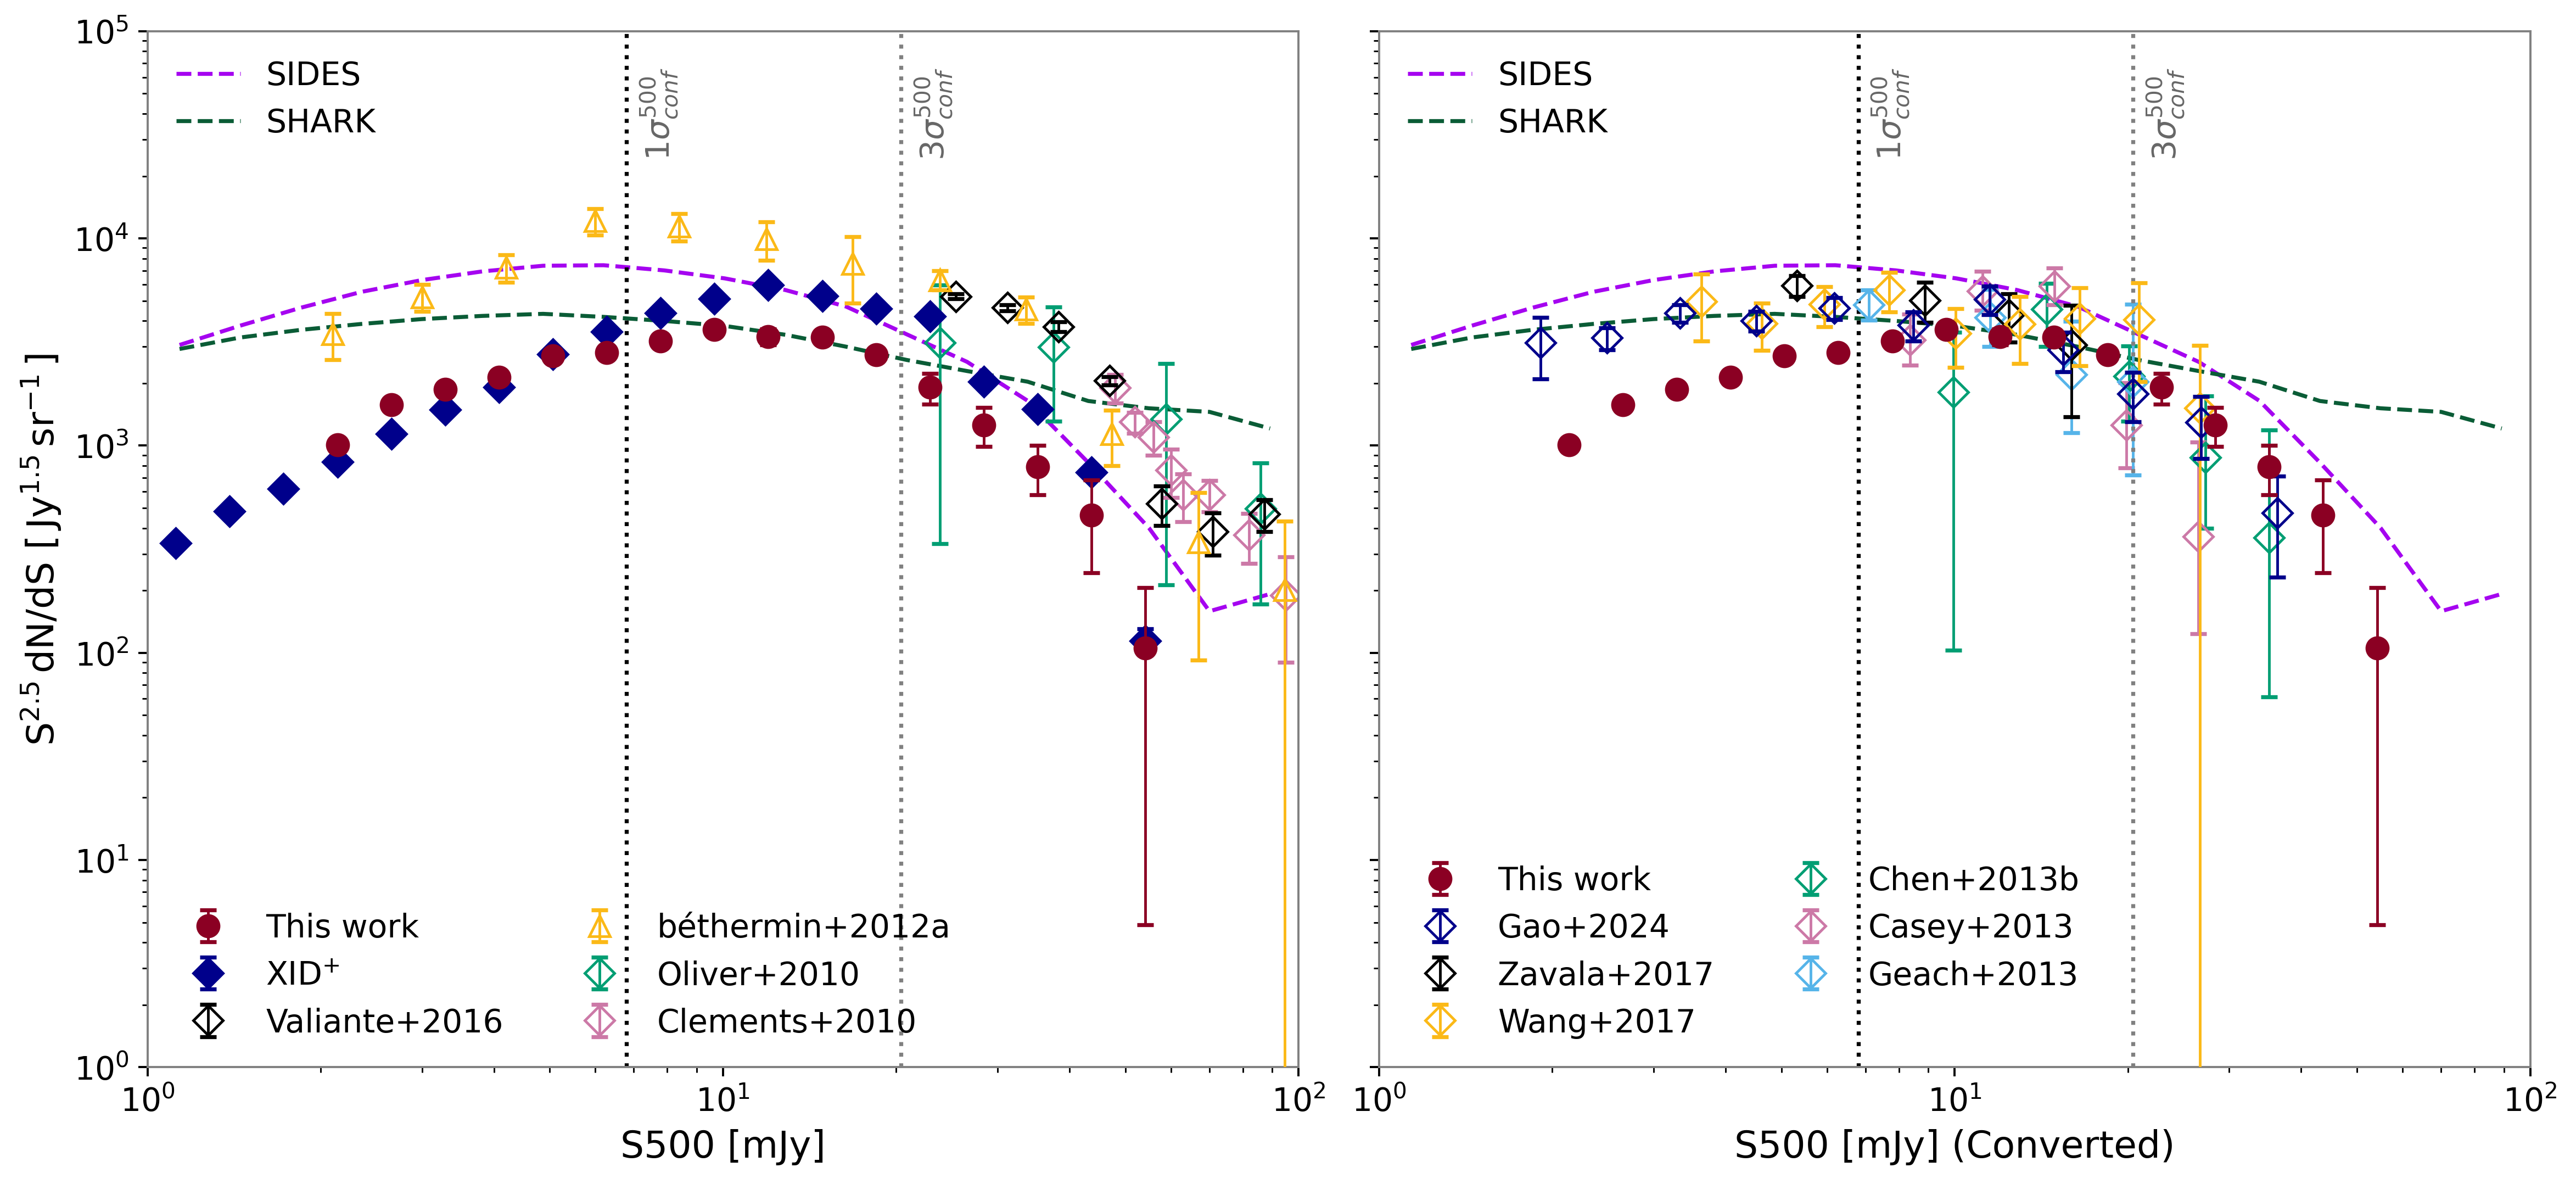

In [18]:
sim_data = [
    {"flux": flux_sides, "renormalized_counts": renormalized_counts_sides, "label": "SIDES", "color": "#A504F0", "zorder":1, "lw":1.5},
    # {"flux": flux_spritz, "renormalized_counts": renormalized_counts_spritz, "label": "SPRITZ", "color": '#BF40BF', "zorder":1},
    {"flux": flux_shark, "renormalized_counts": renormalized_counts_shark, "label": "SHARK", "color": '#0a5c36', "zorder":1, "lw":1.5}
]

obs_data_herschel500 = [
    {"flux": flux_sr, "renormalized_counts": renormalized_counts_sr, "u_err": err_sr, "l_err": err_sr, "label": "This work", "color": '#8b0023', "fmt":"o", 'mfc':'#8b0023', "zorder":5},
    {"flux": flux_xid, "renormalized_counts": renormalized_counts_xid, "u_err": err_xid, "l_err": err_xid, "label": r"XID$^{+}$", "color": '#00008B', "fmt":"D", "mfc":'#00008B', "zorder":4},
    {"flux": valiante_flux, "renormalized_counts": renormalized_counts_valiante, "u_err": err_valiante, "l_err": err_valiante, "label": "Valiante+2016", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": bethermin_flux, "renormalized_counts": renormalized_counts_bethermin, "u_err": err_bethermin, "l_err": err_bethermin, "label": "béthermin+2012a", "color": '#fbb917', "fmt":"^", "mfc":'none', "zorder":3},
    {"flux": oliver_flux, "renormalized_counts": renormalized_counts_oliver, "u_err": err_oliver, "l_err": err_oliver, "label": "Oliver+2010", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": clements_flux, "renormalized_counts": renormalized_counts_clements, "u_err": err_clements, "l_err": err_clements, "label": "Clements+2010", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},

]

obs_data_sc450 = [
    {"flux": flux_sr, "renormalized_counts": renormalized_counts_sr, "u_err": err_sr, "l_err": err_sr, "label": "This work", "color": '#8b0023', "fmt":"o", 'mfc':'#8b0023', "zorder":5},
    {"flux": gao_flux, "renormalized_counts": renormalized_counts_gao, "u_err": err_gao, "l_err": err_gao, "label": "Gao+2024", "color": '#00008B', "fmt":"D", "mfc":'none', "zorder":4},
    {"flux": zavala_flux, "renormalized_counts": renormalized_counts_zavala, "u_err": err_zavala, "l_err": err_zavala, "label": "Zavala+2017", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": wang_flux, "renormalized_counts": renormalized_counts_wang, "u_err": err_wang, "l_err": err_wang, "label": "Wang+2017", "color": '#fbb917', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": chen_flux, "renormalized_counts": renormalized_counts_chen, "u_err": err1_chen, "l_err": err2_chen, "label": "Chen+2013b", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": casey_flux, "renormalized_counts": renormalized_counts_casey, "u_err": err1_casey, "l_err": err2_casey, "label": "Casey+2013", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": geach_flux, "renormalized_counts": renormalized_counts_geach, "u_err": err1_geach, "l_err": err2_geach, "label": "Geach+2013", "color": '#56B4E9', "fmt":"D", "mfc":'none', "zorder":2},

]

def number_count_plot(sim_data, obs_data, ax, xylabel, sigma_confusion):
    # Some fixed configuration settings of the plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1, 100])
    ax.set_ylim([1, 1e5])

    # First, plot the simulated data
    sim_handles = []
    for data_dict in sim_data:
        handle = ax.plot(data_dict["flux"], data_dict["renormalized_counts"], linestyle='--', color=data_dict["color"], label=data_dict["label"], 
                         lw=1 if "lw" not in data_dict.keys() else data_dict["lw"], zorder=data_dict["zorder"])
        sim_handles.append(handle[0])  # Append the line handle directly

    obs_handles = []
    # Finally, plot the observational data
    for data_dict in obs_data:
        handle = ax.errorbar(data_dict["flux"], data_dict["renormalized_counts"], 
                            yerr=[data_dict["l_err"], data_dict["u_err"]],
                            fmt=data_dict["fmt"], color=data_dict["color"], label=data_dict["label"],
                            markerfacecolor=data_dict["mfc"], capsize=3, capthick=1.5, elinewidth=1, markersize=8, zorder=data_dict["zorder"])
        obs_handles.append(handle)  # This will be a tuple, keep it as is

    # Add vertical lines for 3σ and 5σ confusion levels
    ax.axvline(1 * sigma_confusion, color='black', linestyle=':', lw=1.5)
    ax.axvline(3 * sigma_confusion, color='gray', linestyle=':', lw=1.5)

    # Annotate confusion levels
    ax.text(1 * sigma_confusion * 1.05, 4e4, r'1$\sigma^{500}_{conf}$', color='black', fontsize=12, rotation=90, va='center', alpha=0.6)
    ax.text(3 * sigma_confusion * 1.05, 4e4, r'3$\sigma^{500}_{conf}$', color='black', fontsize=12, rotation=90, va='center', alpha=0.6)

    # Labels and grid for first plot
    ax.set_xlabel(xylabel[0], fontsize=14)
    ax.set_ylabel(xylabel[1], fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    # Create legends for simulated and observational data separately
    legend1 = ax.legend(handles=sim_handles, labels=[data_dict["label"] for data_dict in sim_data], loc='upper left', fontsize=12, frameon=False)
    legend2 = ax.legend(handles=obs_handles, labels=[data_dict["label"] for data_dict in obs_data], loc='lower left', fontsize=12, frameon=False, ncol=2)

    ax.add_artist(legend1)

    # More focus on content
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['left'].set_color('gray')

sigma_conf = 6.8

# Figure, with Y-axis shared
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True, gridspec_kw={'wspace': .07}, dpi=350)

number_count_plot(sim_data, obs_data_herschel500, ax1, xylabel=['S500 [mJy]', r'$ \text{S}^{2.5}\, \text{dN/dS} \, \, [\, \mathrm{Jy}^{1.5} \, \mathrm{sr}^{-1}\,]$'], sigma_confusion=sigma_conf)
number_count_plot(sim_data, obs_data_sc450, ax2, xylabel=['S500 [mJy] (Converted)', ''], sigma_confusion=sigma_conf)

# Adjust layout to make sure everything fits well
plt.savefig("number_counts.pdf", bbox_inches='tight')
plt.show()

### Plot the corrected number counts

#### Compute the correction factor
Note: This requires also extracting sources near the border of the image.

We use a specially made input catalog that includes sources near the border.

In [19]:
#R_C = compute_R_C(df_input, df_sr, "SSPIRE500", "S500SR", bins=np.logspace(np.log10(2), np.log10(80), 20, base=10), search_radius=4.0)

correction_factor, flux_bins_corr_factor = calculate_correction_factor(
    df_input, df_sr, flux_col_input='SSPIRE500', flux_col_output='S500SR', bins=np.logspace(np.log10(2), np.log10(80), 20, base=10)
)

def interpolate_correction_factor(correction_factor, bins, fluxes):
    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Compute interpolated correction factor at the given fluxes
    interp_corr_factor = np.interp(fluxes, bin_centers, correction_factor, left=correction_factor[0], right=correction_factor[-1])
    return interp_corr_factor

In [20]:
# def corrected_number_counts(counts, flux_centers, R_grid, C_grid, flux_grid):
    
#     # Interpolate R and C to the flux centers
#     interp_R = np.interp(flux_centers, flux_grid, R_grid, left=np.nan, right=np.nan)
#     interp_C = np.interp(flux_centers, flux_grid, C_grid, left=np.nan, right=np.nan)

#     # Correct the counts
#     corrected_counts = counts * (interp_R / interp_C)
#     print(interp_R/interp_C)
#     return corrected_counts

# # compute flux bin centers corresponding to the grid R, C were computed on
# bin_centers = R_C['Flux bin'].apply(lambda b: (b[0] + b[1]) / 2).values

In [21]:
# Corrected number counts with bootstrap errors for SR catalog
bootstrap_counts_array_corrected = [interpolate_correction_factor(correction_factor, flux_bins_corr_factor, flux_sr) * bootstrapped_counts
                                    for bootstrapped_counts in bootstrap_counts_array]

# Stack bootstrap realizations; each row corresponds to one replicate
bootstrap_counts_array_corrected = np.array(bootstrap_counts_array_corrected)

# Compute the mean and standard deviation at each flux bin over all replicates
median_counts_corrected = np.mean(bootstrap_counts_array_corrected, axis=0)
std_counts_corrected = np.std(bootstrap_counts_array_corrected, axis=0)

flux_sr = flux_val
corrected_renormalized_counts_sr = median_counts_corrected
corrected_err_sr = std_counts_corrected

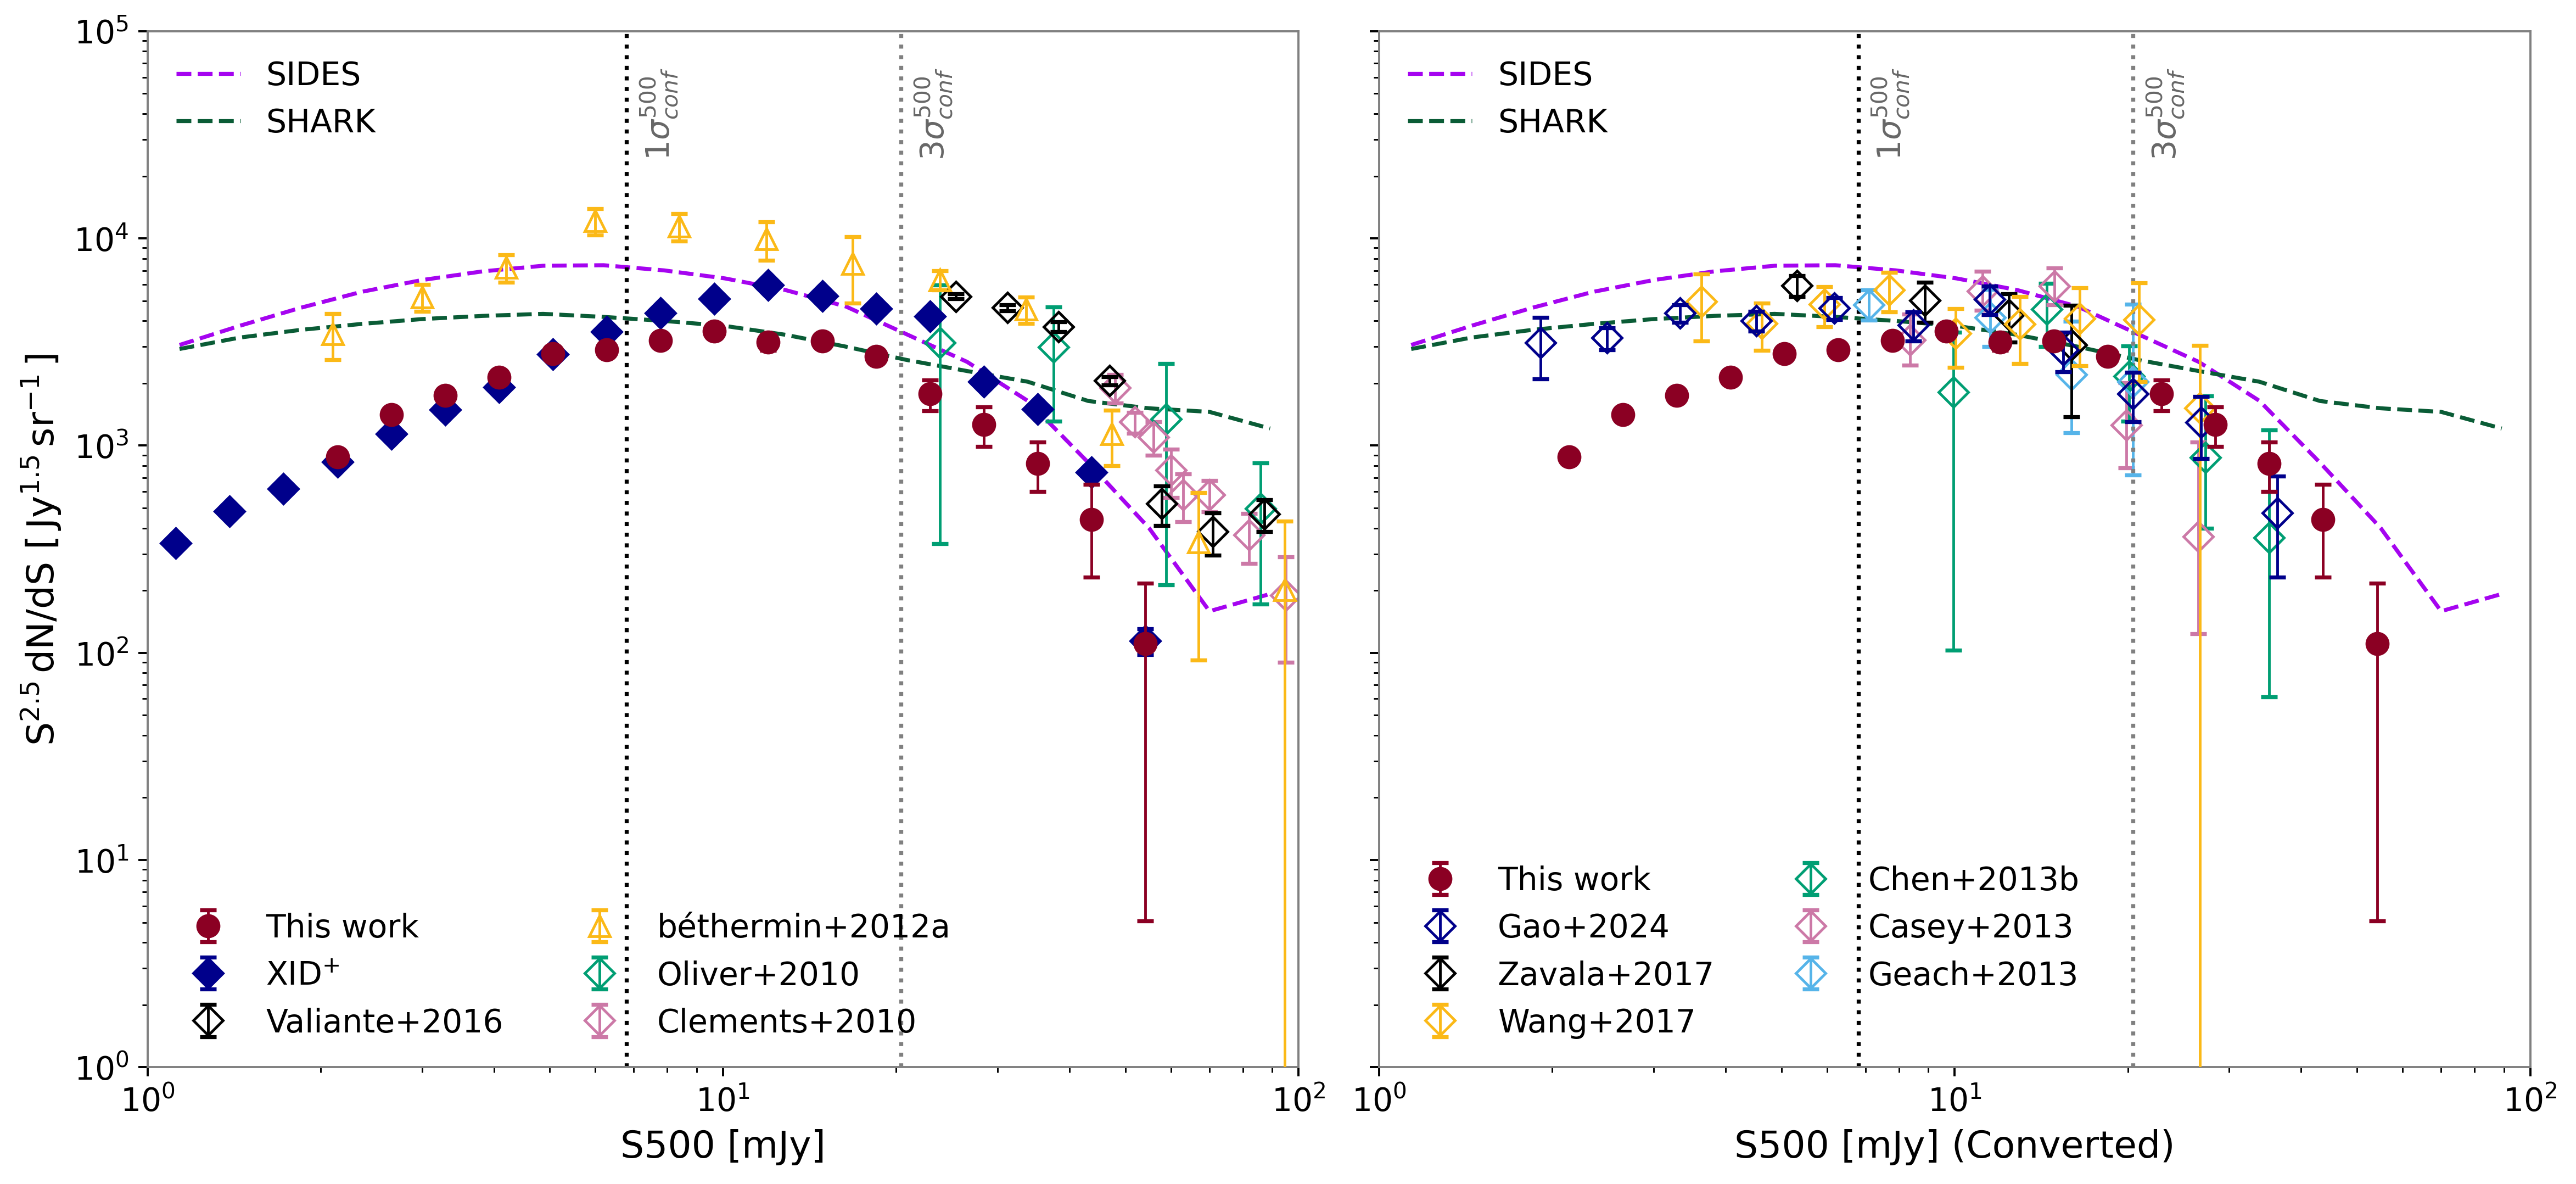

In [22]:
obs_data_herschel500 = [
    {"flux": flux_sr, "renormalized_counts": corrected_renormalized_counts_sr, "u_err": corrected_err_sr, "l_err": corrected_err_sr, "label": "This work", "color": '#8b0023', "fmt":"o", 'mfc':'#8b0023', "zorder":5},
    {"flux": flux_xid, "renormalized_counts": renormalized_counts_xid, "u_err": err_xid, "l_err": err_xid, "label": r"XID$^{+}$", "color": '#00008B', "fmt":"D", "mfc":'#00008B', "zorder":4},
    {"flux": valiante_flux, "renormalized_counts": renormalized_counts_valiante, "u_err": err_valiante, "l_err": err_valiante, "label": "Valiante+2016", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": bethermin_flux, "renormalized_counts": renormalized_counts_bethermin, "u_err": err_bethermin, "l_err": err_bethermin, "label": "béthermin+2012a", "color": '#fbb917', "fmt":"^", "mfc":'none', "zorder":3},
    {"flux": oliver_flux, "renormalized_counts": renormalized_counts_oliver, "u_err": err_oliver, "l_err": err_oliver, "label": "Oliver+2010", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": clements_flux, "renormalized_counts": renormalized_counts_clements, "u_err": err_clements, "l_err": err_clements, "label": "Clements+2010", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},

]

obs_data_sc450 = [
    {"flux": flux_sr, "renormalized_counts": corrected_renormalized_counts_sr, "u_err": corrected_err_sr, "l_err": corrected_err_sr, "label": "This work", "color": '#8b0023', "fmt":"o", 'mfc':'#8b0023', "zorder":5},
    {"flux": gao_flux, "renormalized_counts": renormalized_counts_gao, "u_err": err_gao, "l_err": err_gao, "label": "Gao+2024", "color": '#00008B', "fmt":"D", "mfc":'none', "zorder":4},
    {"flux": zavala_flux, "renormalized_counts": renormalized_counts_zavala, "u_err": err_zavala, "l_err": err_zavala, "label": "Zavala+2017", "color": '#000000', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": wang_flux, "renormalized_counts": renormalized_counts_wang, "u_err": err_wang, "l_err": err_wang, "label": "Wang+2017", "color": '#fbb917', "fmt":"D", "mfc":'none', "zorder":3},
    {"flux": chen_flux, "renormalized_counts": renormalized_counts_chen, "u_err": err1_chen, "l_err": err2_chen, "label": "Chen+2013b", "color": '#009E73', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": casey_flux, "renormalized_counts": renormalized_counts_casey, "u_err": err1_casey, "l_err": err2_casey, "label": "Casey+2013", "color": '#CC79A7', "fmt":"D", "mfc":'none', "zorder":2},
    {"flux": geach_flux, "renormalized_counts": renormalized_counts_geach, "u_err": err1_geach, "l_err": err2_geach, "label": "Geach+2013", "color": '#56B4E9', "fmt":"D", "mfc":'none', "zorder":2},

]

# Figure, with Y-axis shared
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True, gridspec_kw={'wspace': .07}, dpi=350)

number_count_plot(sim_data, obs_data_herschel500, ax1, xylabel=['S500 [mJy]', r'$ \text{S}^{2.5}\, \text{dN/dS} \, \, [\, \mathrm{Jy}^{1.5} \, \mathrm{sr}^{-1}\,]$'], sigma_confusion=sigma_conf)
number_count_plot(sim_data, obs_data_sc450, ax2, xylabel=['S500 [mJy] (Converted)', ''], sigma_confusion=sigma_conf)

# Adjust layout to make sure everything fits well
plt.savefig("corrected_number_counts.pdf", bbox_inches='tight')
plt.show()

#### Plot interpolated correction factor

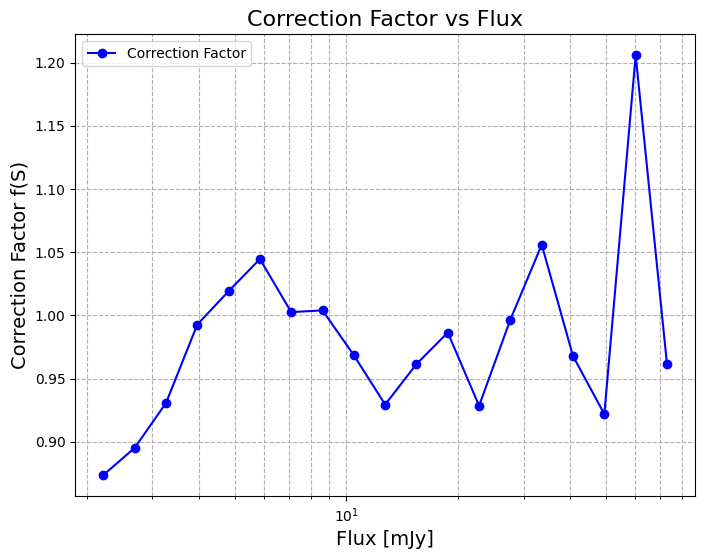

In [26]:
# Calculate bin centers for plotting
bin_centers = (flux_bins_corr_factor[:-1] + flux_bins_corr_factor[1:]) / 2

# Plot the correction factor
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, correction_factor, marker='o', linestyle='-', color='blue', label='Correction Factor')
plt.xscale('log')
plt.xlabel('Flux [mJy]', fontsize=14)
plt.ylabel('Correction Factor f(S)', fontsize=14)
plt.title('Correction Factor vs Flux', fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [23]:
corrected_renormalized_counts_sr

array([   0.        ,    0.        ,    0.        ,  882.32397387,
       1410.4844699 , 1744.69698637, 2134.75461394, 2771.5146098 ,
       2892.88309685, 3210.34749568, 3566.08074432, 3160.70560604,
       3194.3583938 , 2702.17865964, 1777.07581223, 1262.8633111 ,
        818.37515634,  440.22546124,  110.66848943])

In [24]:
renormalized_counts_sr

array([   0.        ,    0.        ,    0.        , 1010.00863907,
       1578.6071339 , 1870.29755572, 2142.64787678, 2703.25337321,
       2808.69262512, 3200.17970704, 3624.6039668 , 3355.4717166 ,
       3345.48636649, 2745.5552333 , 1910.28165152, 1257.50413624,
        790.3271093 ,  462.28066685,  105.57930778])

In [25]:
correction_factor

array([0.87358062, 0.89514686, 0.93058508, 0.99267332, 1.01910149,
       1.04457041, 1.00254987, 1.00392724, 0.96846065, 0.92941656,
       0.96141269, 0.98640167, 0.92845528, 0.99669967, 1.05586592,
       0.96774194, 0.921875  , 1.20588235, 0.96153846])